<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-Necessary-Libraries" data-toc-modified-id="Importing-Necessary-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Necessary Libraries</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modelling</a></span></li><li><span><a href="#Forecasting" data-toc-modified-id="Forecasting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Forecasting</a></span><ul class="toc-item"><li><span><a href="#Exploration" data-toc-modified-id="Exploration-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Exploration</a></span></li></ul></li></ul></div>

# Importing Necessary Libraries

In [1]:
# Importing general libraries
import numpy as np
import pandas as pd

# Importing libraries for preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Importing modelling and evaluation tools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy.stats import randint

# Misc.
import hashlib

2024-08-02 01:45:25.249245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Adjusting display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_columns', 200)
sns.set_theme()

# Preprocessing

In [3]:
df=pd.read_csv('Data/Wide Dataset.csv')

In [4]:
df_panel=pd.read_csv('Data/Panel Encoded.csv')

In [5]:
df_panel=df_panel.drop('Company ID', axis=1)

In [ ]:
train_list = []
val_list = []
test_list = []

company_names = df_panel['Company Name'].unique()

for company_name in company_names:
    company_data = df_panel[df_panel['Company Name'] == company_name]
    num_rows = company_data.shape[0]
    print(f"Company Name: {company_name}, Total Rows: {num_rows}")
    
    if num_rows > 2:  
        company_data = company_data.sort_values(by='Year')
        train_split_index = int(0.7 * num_rows)
        val_split_index = int(0.85 * num_rows)
        
        train_data = company_data.iloc[:train_split_index]
        val_data = company_data.iloc[train_split_index:val_split_index]
        test_data = company_data.iloc[val_split_index:]
        
        train_list.append(train_data)
        val_list.append(val_data)
        test_list.append(test_data)
    elif num_rows > 1:  
        company_data = company_data.sort_values(by='Year')
        split_index = int(0.8 * num_rows)
        train_data = company_data.iloc[:split_index]
        test_data = company_data.iloc[split_index:]
        train_list.append(train_data)
        test_list.append(test_data)
    else:
        train_list.append(company_data)

train_df = pd.concat(train_list)
val_df = pd.concat(val_list)
test_df = pd.concat(test_list)


In [7]:
df_panel.reset_index(inplace=True)
df_panel.set_index(['Company Name', 'Year'], inplace=True)

In [8]:
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)
train_df.set_index(['Company Name', 'Year'], inplace=True)
val_df.set_index(['Company Name', 'Year'], inplace=True)
test_df.set_index(['Company Name', 'Year'], inplace=True)

train_df=train_df.drop('index', axis=1)
val_df=val_df.drop('index', axis=1)
test_df=test_df.drop('index', axis=1)

In [9]:
from sklearn.compose import ColumnTransformer

scaler = MinMaxScaler(feature_range=(0, 1))
column_transformer = ColumnTransformer(
    transformers=[
        ('scaler', scaler, ['Employment', 'GVA'])
    ],
    remainder='passthrough'
)


def prepare_lstm_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [10]:
train_values = train_df['GVA'].values
print(f"Original train_values shape: {train_values.shape}")

train_values_scaled = scaler.fit_transform(train_values.reshape(-1, 1))
print(f"Scaled train_values shape: {train_values_scaled.shape}")


Original train_values shape: (8835,)
Scaled train_values shape: (8835, 1)


In [11]:
time_steps = 1
X_train, y_train = prepare_lstm_data(train_values_scaled, time_steps)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


X_train shape: (8834, 1, 1), y_train shape: (8834, 1)


In [12]:
val_values = val_df['GVA'].values
val_values_scaled = scaler.transform(val_values.reshape(-1, 1))
X_val, y_val = prepare_lstm_data(val_values_scaled, time_steps)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_val shape: (2353, 1, 1), y_val shape: (2353, 1)


# Modelling

In [13]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=False, input_shape=(time_steps, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1, validation_data=(X_val, y_val))

Epoch 1/30
277/277 [==============================] - 4s 6ms/step - loss: 2.7603e-04 - val_loss: 5.1617e-04
Epoch 2/30
277/277 [==============================] - 1s 3ms/step - loss: 2.5634e-04 - val_loss: 5.1744e-04
Epoch 3/30
277/277 [==============================] - 1s 2ms/step - loss: 2.4119e-04 - val_loss: 5.2834e-04
Epoch 4/30
277/277 [==============================] - 1s 2ms/step - loss: 2.3147e-04 - val_loss: 5.3910e-04
Epoch 5/30
277/277 [==============================] - 1s 2ms/step - loss: 2.0418e-04 - val_loss: 5.5355e-04
Epoch 6/30
277/277 [==============================] - 1s 2ms/step - loss: 2.0304e-04 - val_loss: 5.7071e-04
Epoch 7/30
277/277 [==============================] - 1s 2ms/step - loss: 1.9128e-04 - val_loss: 5.9025e-04
Epoch 8/30
277/277 [==============================] - 1s 2ms/step - loss: 2.0095e-04 - val_loss: 6.3073e-04
Epoch 9/30
277/277 [==============================] - 1s 2ms/step - loss: 1.9078e-04 - val_loss: 6.1696e-04
Epoch 10/30
277/277 [=======

In [14]:
train_predictions = lstm_model.predict(X_train)
train_residuals = (y_train - train_predictions).flatten()

277/277 [==============================] - 1s 1ms/step


In [15]:
X_train_rf = train_df.drop(columns=['GVA']).iloc[time_steps:].values
y_train_rf = train_residuals[:len(X_train_rf)]

print(f"X_train_rf shape: {X_train_rf.shape}")
print(f"y_train_rf shape: {y_train_rf.shape}")

X_train_rf shape: (8834, 5)
y_train_rf shape: (8834,)


In [16]:
rf_model = RandomForestRegressor(random_state=42)

# Defining and setting up a parameter grid for RandomizedSearchCV

param_dist = {
    'n_estimators': randint(50, 200),
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=100, cv=5, scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, random_state=42)

# Performing the random search
random_search.fit(X_train_rf, y_train_rf.ravel())

# Finding the best parameters from the search
best_params_random = random_search.best_params_

print(f"Best parameters from RandomizedSearchCV: {best_params_random}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters from RandomizedSearchCV: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 57}


In [17]:
# Defining a narrower parameter grid for grid search based on results from random search
param_grid = {
    'n_estimators': [best_params_random['n_estimators'] - 10, best_params_random['n_estimators'], best_params_random['n_estimators'] + 10],
    'max_features': [best_params_random['max_features']],
    'max_depth': [None if best_params_random['max_depth'] is None else max(1, best_params_random['max_depth'] - 10), 
                  best_params_random['max_depth'], 
                  None if best_params_random['max_depth'] is None else best_params_random['max_depth'] + 10],
    'min_samples_split': [max(2, best_params_random['min_samples_split'] - 1), best_params_random['min_samples_split'], best_params_random['min_samples_split'] + 1],
    'min_samples_leaf': [max(1, best_params_random['min_samples_leaf'] - 1), best_params_random['min_samples_leaf'], best_params_random['min_samples_leaf'] + 1]
}

param_grid['min_samples_split'] = [max(2, x) for x in param_grid['min_samples_split']]
param_grid['min_samples_leaf'] = [max(1, x) for x in param_grid['min_samples_leaf']]

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Performing the grid search
grid_search.fit(X_train_rf, y_train_rf.ravel())

# Getting the best parameters and estimator
best_params_grid = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print(f"Best parameters from GridSearchCV: {best_params_grid}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters from GridSearchCV: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 67}


In [18]:
train_residuals_rf = best_rf_model.predict(X_train_rf)
train_final_predictions = train_predictions + train_residuals_rf.reshape(-1, 1)

In [19]:
test_values = test_df['GVA'].values
test_values_scaled = scaler.transform(test_values.reshape(-1, 1))
X_test, y_test = prepare_lstm_data(test_values_scaled, time_steps)


In [20]:
test_predictions_lstm = lstm_model.predict(X_test)

122/122 [==============================] - 0s 2ms/step


In [21]:
X_test_rf = test_df.iloc[time_steps:].drop(columns=['GVA']).values


In [22]:
test_residuals_rf = best_rf_model.predict(X_test_rf)

In [23]:
final_predictions = test_predictions_lstm + test_residuals_rf.reshape(-1, 1)

In [24]:
final_predictions[:5], y_test[:5]

(array([[ 0.00038641],
        [ 0.00054374],
        [-0.00065516],
        [ 0.00046318],
        [ 0.00040225]]),
 array([[0.00047587],
        [0.00061402],
        [0.00046504],
        [0.00052218],
        [0.00048461]]))

In [25]:
final_predictions_inverse = scaler.inverse_transform(final_predictions)
test_values_inverse = scaler.inverse_transform(test_values_scaled[:len(final_predictions)])

actual_values = test_values_inverse.flatten()
predicted_values_lstm = scaler.inverse_transform(test_predictions_lstm).flatten()
predicted_values_hybrid = final_predictions_inverse.flatten()

In [26]:
final_prediction_df = pd.DataFrame(final_predictions_inverse, columns =['Predicted GVA']) 

final_prediction_df

,Predicted GVA
0,-10970.299523
1,81870.146823
2,-625623.207211
3,34331.672890
4,-1624.597809
...,...
3878,17451.279464
3879,39802.645143
3880,11661.350000
3881,35267.609854


In [27]:
actual_values_df = pd.DataFrame(test_values_inverse, columns =['Actual GVA']) 
comparison = final_prediction_df.join(actual_values_df)

In [28]:
comparison.head(10)

,Predicted GVA,Actual GVA
0,-10970.299523,93960.0
1,81870.146823,41818.0
2,-625623.207211,123347.0
3,34331.672890,35429.0
4,-1624.597809,69149.0
5,51273.666042,46980.0
6,172902.271613,58000.0
7,160966.852236,232000.0
8,12561.382628,58000.0
9,7943.877489,42920.0


In [29]:
drop_2_cv_rmse_inv = np.sqrt(mean_squared_error(test_values_inverse, final_predictions_inverse))
print(f'Root Mean Squared Error on Test Set (Original Scale): {drop_2_cv_rmse_inv}')

drop_2_cv_mae_inv = mean_absolute_error(test_values_inverse, final_predictions_inverse)
print(f'Mean Absolute Error on Test Set (Original Scale): {drop_2_cv_mae_inv}')

drop_2_cv_r2_inv = r2_score(test_values_inverse, final_predictions_inverse)
print(f'R-squared on Test Set (Original Scale): {drop_2_cv_r2_inv}')

drop_2_cv_mape_inv = mean_absolute_percentage_error(test_values_inverse, final_predictions_inverse)
print(f'Mean Absolute Percentage Error on Train Set (Original Scale): {drop_2_cv_mape_inv}')

Root Mean Squared Error on Test Set (Original Scale): 7893364.78761774
Mean Absolute Error on Test Set (Original Scale): 924299.0121165597
R-squared on Test Set (Original Scale): 0.7467224680256177
Mean Absolute Percentage Error on Train Set (Original Scale): 8.328526413111943


In [30]:
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1)
train_final_predictions_original = scaler.inverse_transform(train_final_predictions).reshape(-1)

drop_2_cv_rmse_train_inv = np.sqrt(mean_squared_error(y_train_original, train_final_predictions_original))
print(f'Root Mean Squared Error on Train Set (Original Scale): {drop_2_cv_rmse_train_inv}')

drop_2_cv_mae_train_inv = mean_absolute_error(y_train_original, train_final_predictions_original)
print(f'Mean Absolute Error on Train Set (Original Scale): {drop_2_cv_mae_train_inv}')

drop_2_cv_r2_train_inv = r2_score(y_train_original, train_final_predictions_original)
print(f'R-squared on Train Set (Original Scale): {drop_2_cv_r2_train_inv}')


Root Mean Squared Error on Train Set (Original Scale): 5231789.628135296
Mean Absolute Error on Train Set (Original Scale): 530478.6583992995
R-squared on Train Set (Original Scale): 0.7156368842769771


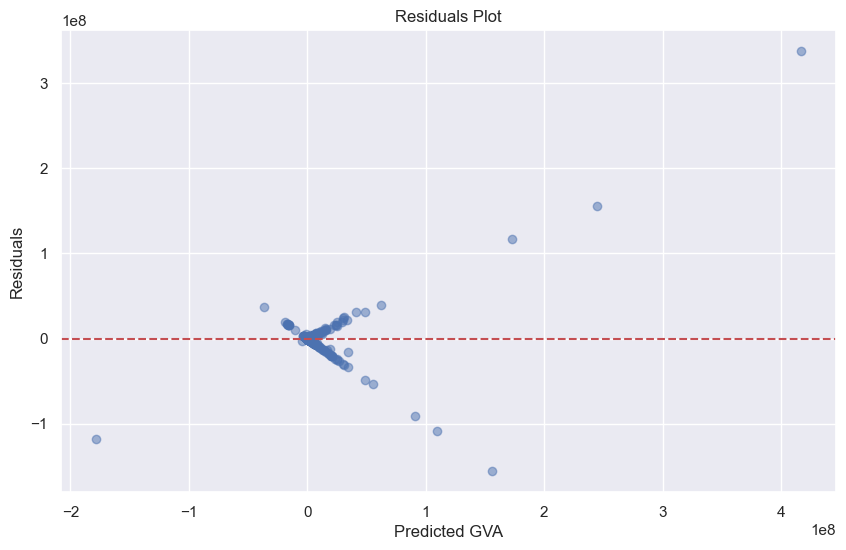

In [31]:
# Creating a residual plot to visualize the prediction accuracy of the model
test_df_reset = test_df.reset_index()

years = test_df_reset['Year'][time_steps:].values

companies = test_df_reset['Company Name'][time_steps:].values

results_df = pd.DataFrame({
    'Company Name': companies,
    'Year': years,
    'Actual_GVA': test_values_inverse.flatten(),
    'Predicted_GVA': final_predictions_inverse.flatten()
})

residuals = results_df['Actual_GVA'] - results_df['Predicted_GVA']

plt.figure(figsize=(10, 6))
plt.scatter(results_df['Predicted_GVA'], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted GVA')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Forecasting

In [32]:
# Filtering for companies that are still active in 2021 (where their GVA is not equal to 0)
active_companies_2021 = df_panel.loc[df_panel.index.get_level_values('Year') == 2021]
active_companies_2021 = active_companies_2021[active_companies_2021['GVA'] != 0]
active_company_ids = active_companies_2021.index.get_level_values('Company Name').unique()

# Creating a DataFrame for 2022 with the same features as 2021 but only for active companies
forecast_df = df_panel.loc[df_panel.index.get_level_values('Company Name').isin(active_company_ids)]
forecast_df = forecast_df.loc[forecast_df.index.get_level_values('Year') == 2021].copy()
forecast_df.reset_index(inplace=True)
forecast_df['Year'] = 2022
forecast_df.set_index(['Company Name', 'Year'], inplace=True)
forecast_df=forecast_df.drop('index', axis=1)

# Preparing data and fitting the LSTM and RF models as done for the test data during modelling
forecast_values = forecast_df['GVA'].values
forecast_values_scaled = scaler.transform(forecast_values.reshape(-1, 1))
X_forecast_lstm, _ = prepare_lstm_data(forecast_values_scaled, time_steps)

forecast_predictions_lstm = lstm_model.predict(X_forecast_lstm)

forecast_df_rf = forecast_df.iloc[time_steps:].copy()
X_forecast_rf = forecast_df_rf.drop(columns=['GVA']).values

forecast_residuals_rf = best_rf_model.predict(X_forecast_rf)

final_forecast_predictions = forecast_predictions_lstm + forecast_residuals_rf.reshape(-1, 1)

# Inverse transforming the predictions to their original scale
final_forecast_predictions_inverse = scaler.inverse_transform(final_forecast_predictions)

forecast_results_df = forecast_df_rf.copy()
forecast_results_df['GVA_Forecast_2022'] = final_forecast_predictions_inverse

forecast_results_df.reset_index(inplace=True)
forecast_results_df = forecast_results_df[['Company Name', 'Year', 'GVA_Forecast_2022']]

82/82 [==============================] - 0s 1ms/step


In [33]:
# Creating a querying function to get the GVA forecast for a specific company
def get_gva_forecast(company_name):
    result = forecast_results_df[forecast_results_df['Company Name'] == company_name]
    if result.empty:
        return f"No forecast data available for company: {company_name}"
    else:
        return result

# Example usage
company_name = 'KING'  # Replace this value with the actual company name to look up (use company house listed names)
company_gva_forecast = get_gva_forecast(company_name)
print(company_gva_forecast)


No forecast data available for company: KING


In [34]:
#Finding the total aggregated industry GVA for 2022
Total = forecast_results_df['GVA_Forecast_2022'].sum()
Total

3192849014.524306

In [35]:
#Finding the Total industry GVA for 2021 as a comparison 
total_2021 = df['Total Company GVA 2021'].sum()

In [36]:
total_2021

3196561255.0

## Exploration

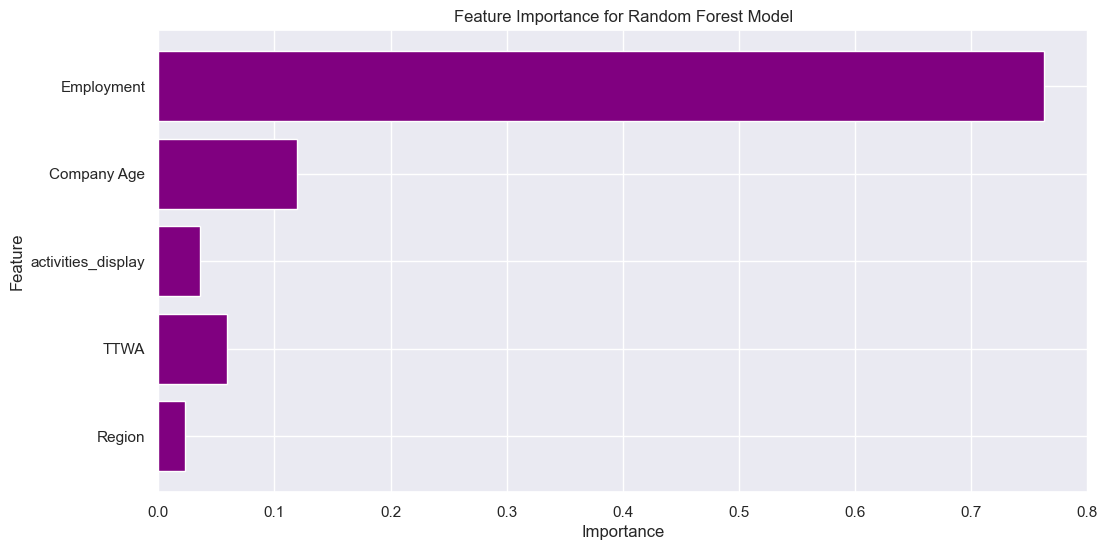

In [37]:
# Getting feature importances from RF
feature_importances = best_rf_model.feature_importances_
features = train_df.drop(columns=['GVA']).columns

plt.figure(figsize=(12, 6))
plt.barh(features, feature_importances, color='purple')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.show()

In [38]:
df_viz=df_panel.reset_index()

In [39]:
# Define the mapping dictionary to decode label encoding done in the primary notebook
region_mapping = {6: 'Scotland',
                   8: 'South West',
                   3: 'North East',
                   7: 'South East',
                   2: 'London',
                   0: 'East Midlands',
                   1: 'East of England',
                   10: 'West Midlands',
                   11: 'Yorkshire and The Humber',
                   9: 'Wales',
                   4: 'North West',
                   5: 'Northern Ireland'}

df_viz['Region'] = df_viz['Region'].map(region_mapping)

forecast_results_df_region = forecast_results_df.merge(df_viz[['Company Name', 'Region']], on='Company Name', how='left')
forecast_results_df_region = forecast_results_df_region.drop_duplicates(subset=['Company Name'], keep='first')

# Aggregating the forecasted GVA values by region
region_gva_2022 = forecast_results_df_region.groupby('Region')['GVA_Forecast_2022'].sum().reset_index()

# Aggregating the 2021 GVA values by region
region_gva_2021 = df.groupby('Region')['Total Company GVA 2021'].sum().reset_index()


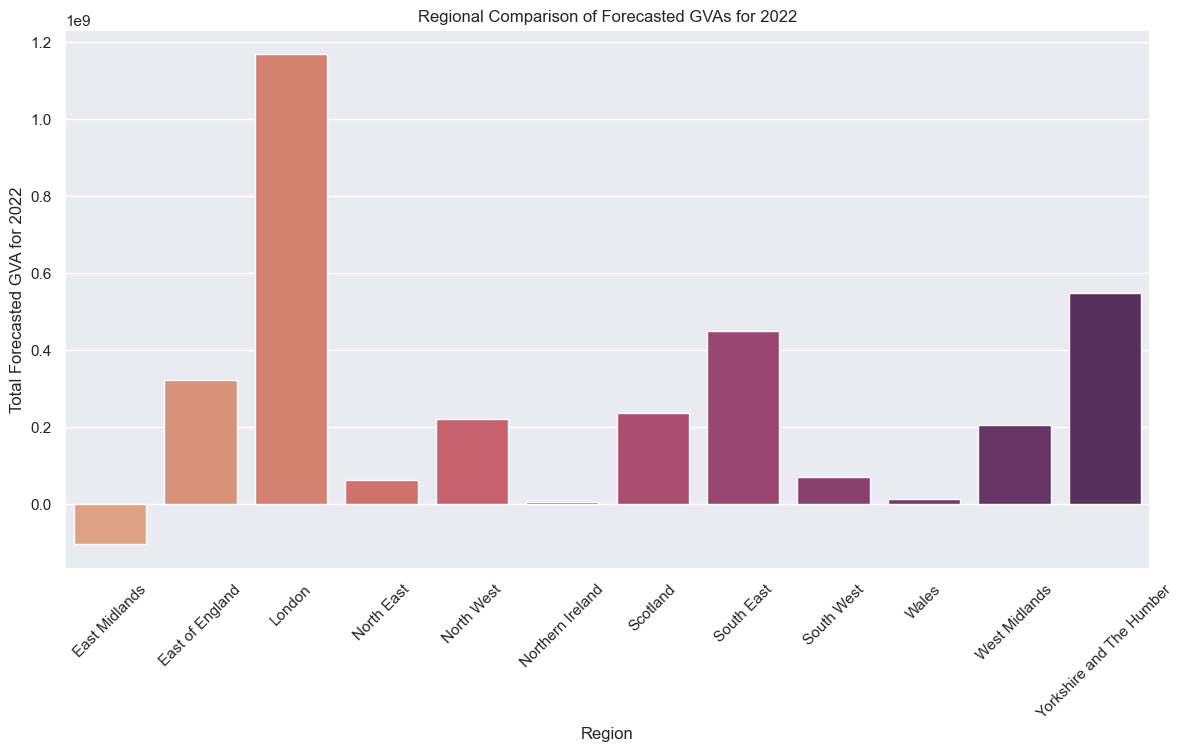

In [40]:
# Region Plot for 2022
plt.figure(figsize=(14, 7))
sns.barplot(x='Region', y='GVA_Forecast_2022', data=region_gva_2022, palette='flare')
plt.xlabel('Region')
plt.ylabel('Total Forecasted GVA for 2022')
plt.title('Regional Comparison of Forecasted GVAs for 2022')
plt.xticks(rotation=45)  
plt.show()

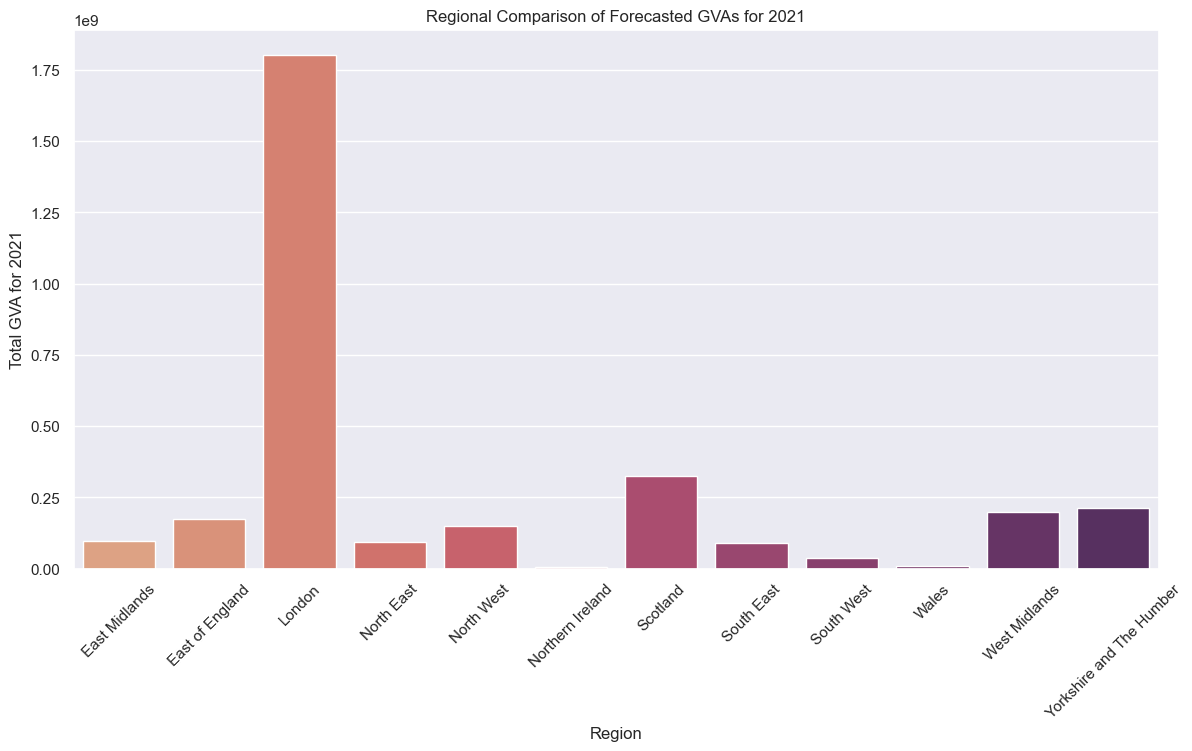

In [41]:
# Region Plot for 2021
plt.figure(figsize=(14, 7))
sns.barplot(x='Region', y='Total Company GVA 2021', data=region_gva_2021, palette='flare')
plt.xlabel('Region')
plt.ylabel('Total GVA for 2021')
plt.title('Regional Comparison of Forecasted GVAs for 2021')
plt.xticks(rotation=45)
plt.show()

In [42]:
# Same for company activity
activity_mapping = {0: 'Games developer', 2: 'Games publisher', 1: 'Games developer & publisher'}

df_viz['activities_display'] = df_viz['activities_display'].map(activity_mapping)

forecast_results_df_act = forecast_results_df.merge(df_viz[['Company Name', 'activities_display']], on='Company Name', how='left')
forecast_results_df_act = forecast_results_df_act.drop_duplicates(subset=['Company Name'], keep='first')

activity_gva_2022 = forecast_results_df_act.groupby('activities_display')['GVA_Forecast_2022'].sum().reset_index()

activity_gva_2021 = df.groupby('activities_display')['Total Company GVA 2021'].sum().reset_index()


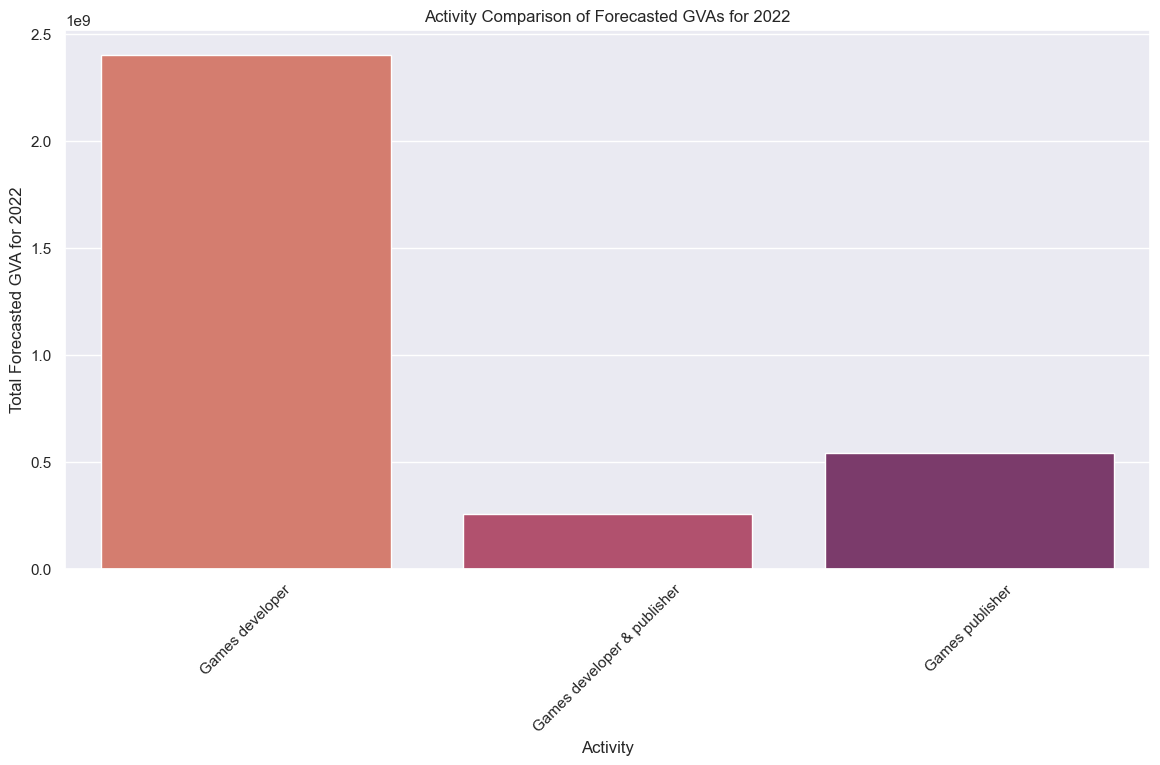

In [43]:
# Activity Plot for 2022
plt.figure(figsize=(14, 7))
sns.barplot(x='activities_display', y='GVA_Forecast_2022', data=activity_gva_2022, palette='flare')
plt.xlabel('Activity')
plt.ylabel('Total Forecasted GVA for 2022')
plt.title('Activity Comparison of Forecasted GVAs for 2022')
plt.xticks(rotation=45)
plt.show()

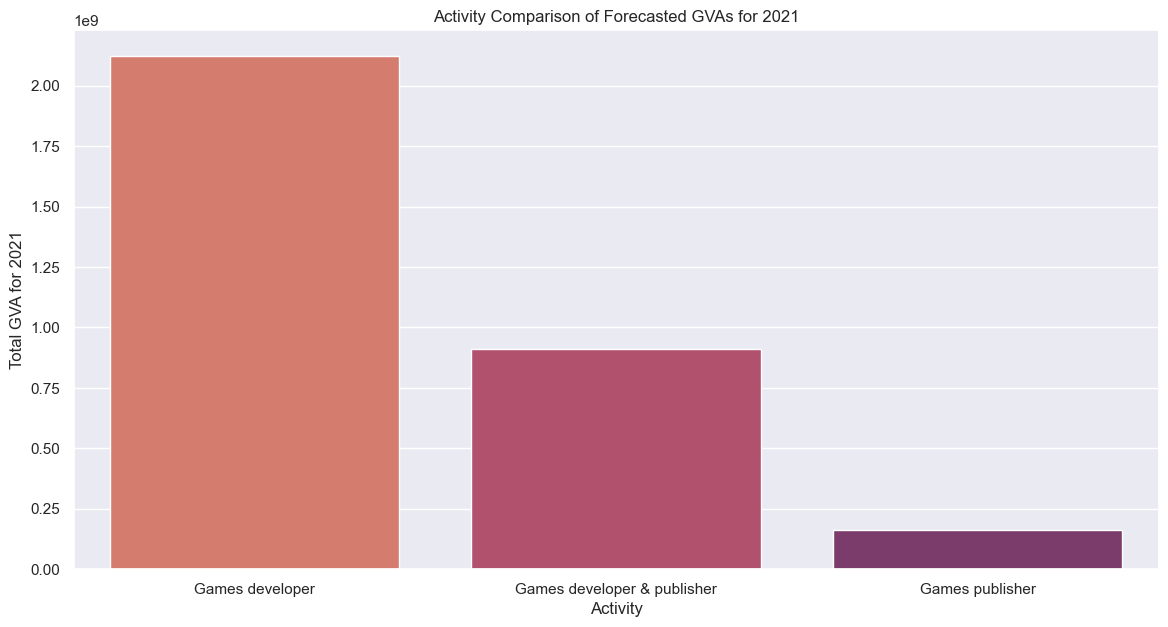

In [44]:
# Activity Plot for 2021
plt.figure(figsize=(14, 7))
sns.barplot(x='activities_display', y='Total Company GVA 2021', data=activity_gva_2021, palette='flare')
plt.xlabel('Activity')
plt.ylabel('Total GVA for 2021')
plt.title('Activity Comparison of Forecasted GVAs for 2021')
plt.xticks()
plt.show()